## Learning to Rank using XGBRanker

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from xgboost import XGBRanker
from sklearn.metrics import ndcg_score, make_scorer
import matplotlib.pyplot as plt
import random
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
features = pd.read_csv('features.csv', header=None)
qid = pd.read_csv('qid.csv', index_col=0)
labels = pd.read_csv('labels.csv', index_col=0)
# putting all together
df = pd.concat([features, qid, labels], axis=1)
df

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,qid,score
0,13.276493,13.051305,NaN,NaN,NaN,13.234222,8.039442,4.544776,19.484780,10.0,...,1.0,19.0,5.0,0.0,NaN,32.0,2.0,1.0,0,4
1,14.404030,13.051305,NaN,NaN,NaN,13.234222,NaN,4.622344,17.500880,10.0,...,1.0,34.0,0.0,0.0,NaN,32.0,2.0,1.0,0,4
2,14.313204,12.979461,12.979741,NaN,NaN,13.175402,NaN,4.240449,0.317460,10.0,...,1.0,12.0,0.0,0.0,NaN,32.0,2.0,1.0,0,4
3,14.313204,12.979461,10.813904,NaN,NaN,13.175402,NaN,4.686657,17.179700,10.0,...,1.0,35.0,0.0,0.0,NaN,32.0,2.0,1.0,0,4
4,14.404030,13.051305,NaN,NaN,NaN,13.234222,NaN,4.622344,0.529101,10.0,...,1.0,34.0,0.0,0.0,NaN,32.0,2.0,1.0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,4.0,...,NaN,0.0,0.0,0.0,NaN,32.0,0.0,NaN,999,0
136430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,5.0,...,NaN,36.0,0.0,0.0,NaN,4.0,0.0,1.0,999,0
136431,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,4.0,...,NaN,0.0,0.0,0.0,NaN,2.0,0.0,NaN,999,0
136432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,...,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,999,0


In [3]:
# deviding data into k samples each of which having a unique qid
def population_sampler(population, k):
    random.seed(123)
    random.shuffle(population)
    return [population[i::k] for i in range(k)]

In [4]:
# getting X, y and group size for each qid
def splitXy(df, fold):
    train = df[~(df.qid.isin(fold))]
    test = df[df.qid.isin(fold)]
    groups = train.groupby('qid').size().values
    X_train = train.drop(['qid','score'], axis=1)
    X_test = test.drop(['score'], axis=1)
    y_train = train.score
    y_test = test.score

    return X_train, X_test, y_train, y_test, groups

In [5]:
# fitting the model: the hyperparameters are not tunned here.
def fit_model(X_train, y_train, groups):
    model = XGBRanker(  
    booster='gbtree',
    objective='rank:ndcg',
    random_state=123,
    learning_rate=0.1,
    colsample_bytree=0.9,
    eta=0.05,
    max_depth=6,
    n_estimators=110,
    subsample=0.75
    )

    return model.fit(X_train, y_train, group=groups, verbose=False)

In [6]:
# making predictions and getting the ndcg score
def predict_score(model, X_test, y_test):
    temp = pd.concat([X_test, y_test], axis=1)[['qid','score']]
    # making the predictions
    temp['prediction'] = model.predict(X_test.drop('qid', axis=1))
    # getting lists of scores and predicted values for each qid
    temp = temp.groupby('qid').agg({'score':list, 'prediction':list}).reset_index()
    # calculating NDCG scores and adding them as in a column
    temp['NDCG'] = temp.apply(lambda x: ndcg_score(np.array([x.score]), np.array([x.prediction])), axis=1)
    
    return temp

In [7]:
# running altogether
def runCV(df):
    # getting the folds
    folds = population_sampler(df.qid.unique(), k=5)
    # instanciating an empty dataframe
    results = pd.DataFrame(columns={'qid','score','prediction','NDCG'})
    
    for i, fold in enumerate(folds):

        X_train, X_test, y_train, y_test, groups = splitXy(df, fold)
        model = fit_model(X_train, y_train, groups)
        temp = predict_score(model, X_test, y_test)

        print ('Fold-%s NDCG Score: %.2f'%(i+1,temp.NDCG.mean()))
        
        # putting all results from all folds in the dataframe
        results = pd.concat([results, temp], axis=0).sort_values('qid').reset_index(drop=True)
        
    print ('\nTotal NDCG Score : %.2f'%results.NDCG.mean())
    
    return results[['qid','NDCG']]

In [8]:
results = runCV(df)

Fold-1 NDCG Score: 0.90
Fold-2 NDCG Score: 0.88
Fold-3 NDCG Score: 0.90
Fold-4 NDCG Score: 0.91
Fold-5 NDCG Score: 0.89

Total NDCG Score : 0.89


In [9]:
results

,qid,NDCG
0,0,0.974488
1,1,0.863719
2,2,0.664793
3,3,0.958847
4,4,1.000000
...,...,...
897,994,0.813069
898,995,0.638018
899,997,0.862441
900,998,0.923004


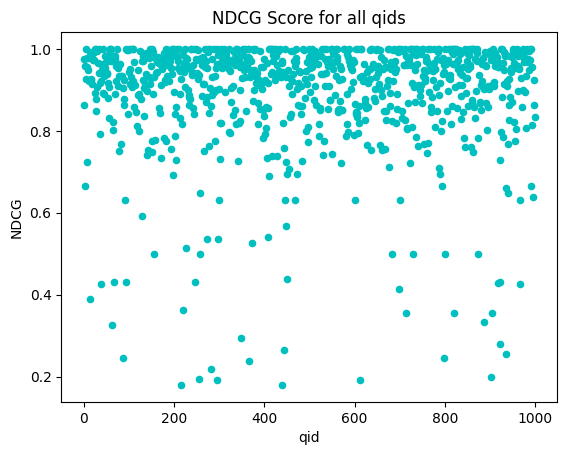

In [10]:
results.plot.scatter(x='qid', y='NDCG', c='c')
plt.title('NDCG Score for all qids')
plt.show()

### Notes
* Missing values were handled by the model (XGboost) itself.
* Hyperparameter tunning could be done in order to improve the efficiency of the model.